In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [6]:
# Import dataset
data = './Wholesale_customers_data.csv'
df = pd.read_csv(data)

In [7]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [8]:
df.shape

(440, 8)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


In [11]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [13]:
X = df.drop('Channel', axis=1)
y = df['Channel']

In [14]:
# convert labels into binary values
y[y == 2] = 0
y[y == 1] = 1

In [15]:
# import XGBoost
import xgboost as xgb

# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [16]:
data_dmatrix

In [17]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [28]:
# import XGBClassifier
from xgboost import XGBClassifier

# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }
         
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)



# fit the classifier to the training data
model = xgb_clf.fit(X_train, y_train)

In [19]:
print(xgb_clf)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=1.0, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=10, ...)


In [20]:
y_pred = xgb_clf.predict(X_test)

In [21]:


# check accuracy score
from sklearn.metrics import accuracy_score

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))



XGBoost model accuracy score: 0.8864


In [22]:
from xgboost import cv

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [23]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.914999,0.009704,0.880965,0.021050
1,0.934374,0.013263,0.923562,0.022810
2,0.936252,0.013723,0.924433,0.025777
3,0.943878,0.009032,0.927152,0.022228
4,0.957881,0.008845,0.935191,0.016437


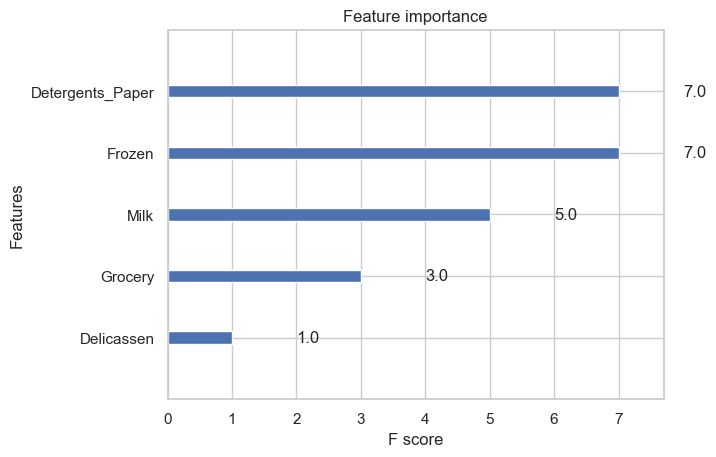

In [24]:
xgb.plot_importance(xgb_clf)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

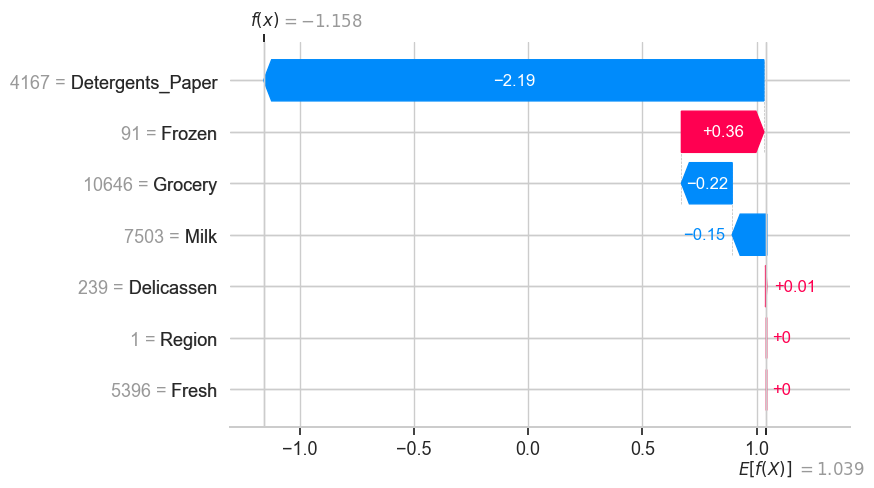

In [29]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])